In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
df = pd.read_fwf('./wili dataset/x_train.txt', header=None)
X_train = df[[0]]
df = pd.read_fwf('./wili dataset/x_test.txt', header=None)
X_test = df[[0]] 

In [3]:
target = pd.read_fwf('./wili dataset/y_train.txt',header = None)
y_train = target[[0]]
target = pd.read_fwf('./wili dataset/y_test.txt',header = None)
y_test = target[[0]]

In [4]:
y_train[y_train == 'be-tara'] = 'be-tarask'
y_train[y_train == 'roa-tar'] = 'roa-tara'

In [5]:
languages = ['eng', 'hin', 'mar', 'guj', 'tam', 'tcy', 'tel', 'pan', 'ben', 'mai']

In [6]:
train_index = y_train.index[y_train[0].isin(languages)].tolist()

In [7]:
test_index = y_test.index[y_test[0].isin(languages)].tolist()

In [8]:
X_train_p = X_train.iloc[train_index,:]
X_test_p = X_test.iloc[test_index,:]

In [9]:
y_train_p = y_train.iloc[train_index, :]
y_test_p = y_test.iloc[test_index, :]

### Tokenize Labels

In [10]:
label2int = {}
int2label = {}
counter = 0
for label in languages:
    if label not in label2int:
        label2int[label] = counter
        int2label[counter] = label
    counter += 1

In [11]:
pickle.dump(label2int, open('label2int.pkl', 'wb'))
pickle.dump(int2label, open('int2label.pkl', 'wb'))

### Tokenize target Variables

In [12]:
y_train_int = []
for label in y_train_p[0]:
    y_train_int.append(label2int[label])

In [13]:
y_test_int = []
for label in y_test_p[0]:
    y_test_int.append(label2int[label])

### Data Preprocessing

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer(analyzer='char',min_df=25,lowercase=True, norm='l2')

In [16]:
vectorizer.fit(X_train_p[0])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=25,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
X_train2int = vectorizer.transform(X_train_p[0]).toarray()

In [18]:
X_test2int = vectorizer.transform(X_test_p[0]).toarray()

In [19]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

### Scaler

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
sc = StandardScaler()

In [24]:
sc.fit(X_train2int)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
X_train2int_sc = sc.transform(X_train2int)
X_test2int_sc = sc.transform(X_test2int)

In [26]:
pickle.dump(sc, open('scaler.pkl', 'wb'))

### PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=80)

In [23]:
pca.fit(X_train2int)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
X_train_pca = pca.transform(X_train2int)

In [25]:
X_test_pca = pca.transform(X_test2int)

In [26]:
import matplotlib.pyplot as plt

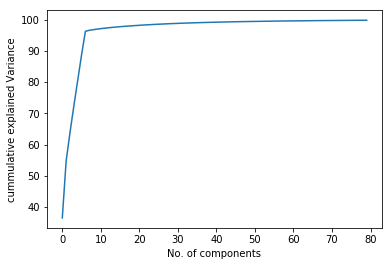

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [28]:
pickle.dump(pca, open('pca.pkl', 'wb'))

### One Hot Encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
y_train_int = np.array(y_train_int).reshape(-1, 1)
y_test_int = np.array(y_test_int).reshape(-1, 1)

In [31]:
enc = OneHotEncoder()

In [32]:
enc.fit(y_train_int)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [33]:
y_train_enc = enc.transform(y_train_int)
y_test_enc = enc.transform(y_test_int)

## Design ANN

In [68]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [69]:
clf = Sequential()
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu', input_dim = 80))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim =10  , kernel_initializer = 'uniform', activation='softmax'))

C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=80, units=60)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  after removing the cwd from sys.path.
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="softmax", units=10)`
  


In [70]:
clf.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [71]:
with tf.device('/gpu:0'):
    history = clf.fit(X_train_pca, y_train_enc, batch_size=16, epochs=100, validation_data=(X_test_pca,y_test_enc))

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 2s 409us/step - loss: 1.2677 - acc: 0.5280 - val_loss: 0.5459 - val_acc: 0.7772
Epoch 2/100
5000/5000 [==============================] - 2s 317us/step - loss: 0.5145 - acc: 0.7744 - val_loss: 0.4543 - val_acc: 0.7936
Epoch 3/100
5000/5000 [==============================] - 2s 321us/step - loss: 0.4598 - acc: 0.7850 - val_loss: 0.4339 - val_acc: 0.7792
Epoch 4/100
5000/5000 [==============================] - 2s 317us/step - loss: 0.4188 - acc: 0.8084 - val_loss: 0.3582 - val_acc: 0.8720
Epoch 5/100
5000/5000 [==============================] - 2s 318us/step - loss: 0.3309 - acc: 0.8732 - val_loss: 0.2666 - val_acc: 0.9224
Epoch 6/100
5000/5000 [==============================] - 2s 331us/step - loss: 0.2777 - acc: 0.8910 - val_loss: 0.2392 - val_acc: 0.9244
Epoch 7/100
5000/5000 [==============================] - 2s 327us/step - loss: 0.2363 - acc: 0.9142 - val_loss: 0.2089 - val_acc: 

5000/5000 [==============================] - 2s 317us/step - loss: 0.0491 - acc: 0.9872 - val_loss: 0.1946 - val_acc: 0.9684
Epoch 61/100
5000/5000 [==============================] - 2s 315us/step - loss: 0.0419 - acc: 0.9878 - val_loss: 0.1963 - val_acc: 0.9668
Epoch 62/100
5000/5000 [==============================] - 2s 316us/step - loss: 0.0407 - acc: 0.9898 - val_loss: 0.2087 - val_acc: 0.9670
Epoch 63/100
5000/5000 [==============================] - 2s 318us/step - loss: 0.0390 - acc: 0.9880 - val_loss: 0.2037 - val_acc: 0.9682
Epoch 64/100
5000/5000 [==============================] - 2s 314us/step - loss: 0.0390 - acc: 0.9886 - val_loss: 0.2051 - val_acc: 0.9686
Epoch 65/100
5000/5000 [==============================] - 2s 313us/step - loss: 0.0387 - acc: 0.9908 - val_loss: 0.2072 - val_acc: 0.9680
Epoch 66/100
5000/5000 [==============================] - 2s 316us/step - loss: 0.0366 - acc: 0.9894 - val_loss: 0.2008 - val_acc: 0.9692
Epoch 67/100
5000/5000 [=======================

In [72]:
from keras.models import model_from_json
model_json = clf.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
clf.save_weights("model.h5")

## Evaluation

In [73]:
y_pred_test_label = clf.predict(X_test_pca)
y_pred_train_label = clf.predict(X_train_pca)

In [74]:
y_pred_test = np.argmax(y_pred_test_label, axis=1)
y_pred_train = np.argmax(y_pred_train_label, axis=1)

In [75]:
y_train_true = y_train_int.astype(np.int)
y_test_true = y_test_int.astype(np.int)

## Graph Plot

### Model Accuracy Graph

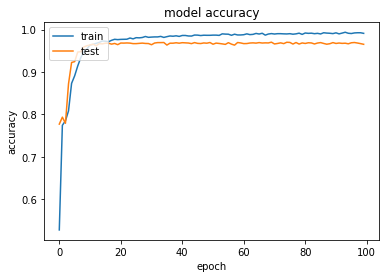

In [76]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Loss Graph

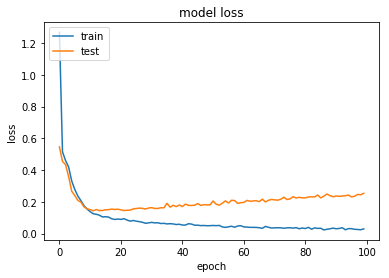

In [77]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Classification Report

In [78]:
from sklearn.metrics import classification_report

#### Train Data report

In [79]:
print(classification_report(y_train_true, y_pred_train))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       500
          1       0.98      1.00      0.99       500
          2       1.00      0.99      1.00       500
          3       1.00      1.00      1.00       500
          4       1.00      1.00      1.00       500
          5       1.00      1.00      1.00       500
          6       1.00      1.00      1.00       500
          7       1.00      1.00      1.00       500
          8       1.00      1.00      1.00       500
          9       1.00      0.98      0.99       500

avg / total       1.00      1.00      1.00      5000



#### Test Data Report

In [80]:
print(classification_report(y_test_true, y_pred_test))

             precision    recall  f1-score   support

          0       0.87      0.92      0.89       500
          1       0.96      0.95      0.96       500
          2       0.98      0.96      0.97       500
          3       0.93      0.98      0.95       500
          4       1.00      0.99      0.99       500
          5       1.00      1.00      1.00       500
          6       0.98      0.97      0.97       500
          7       0.99      0.99      0.99       500
          8       0.99      0.96      0.97       500
          9       0.97      0.94      0.96       500

avg / total       0.97      0.97      0.97      5000



## Confusion Matrix

In [81]:
from sklearn.metrics import confusion_matrix

### Train data

In [82]:
print(confusion_matrix(y_pred_train, y_train_true))

[[499   1   4   2   0   0   1   0   1   0]
 [  0 498   0   0   0   0   0   0   0   9]
 [  0   0 496   0   0   0   0   0   0   0]
 [  1   0   0 498   0   0   1   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  0   0   0   0   0 500   0   0   0   0]
 [  0   0   0   0   0   0 498   0   0   0]
 [  0   0   0   0   0   0   0 500   0   0]
 [  0   0   0   0   0   0   0   0 499   0]
 [  0   1   0   0   0   0   0   0   0 491]]


### Test data

In [83]:
print(confusion_matrix(y_pred_test, y_test_true))

[[459   4   8  11   3   0  14   3  17  10]
 [  1 477   4   0   0   0   0   0   0  15]
 [  5   4 481   0   0   0   0   0   0   2]
 [ 22   3   3 488   1   0   2   4   1   1]
 [  0   1   0   0 494   0   0   0   1   0]
 [  0   0   0   0   0 500   0   0   0   0]
 [  6   2   0   0   0   0 484   0   0   1]
 [  2   0   0   1   1   0   0 493   2   0]
 [  4   0   1   0   1   0   0   0 479   0]
 [  1   9   3   0   0   0   0   0   0 471]]


### Making RNN

In [63]:
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM

In [65]:
# Using RNN
# Initialising classifier
clf = Sequential()
# Adding First Embedded Layer
clf.add(Embedding(150, 128, input_length=X_train_pca.shape[1]))
clf.add(SpatialDropout1D(0.2))

# Adding Lstm Layer
clf.add(LSTM(98, dropout=0.2, recurrent_dropout=0.2))

# Adding fully connected layer
clf.add(Dense(100, activation='relu'))

# Adding output layer
clf.add(Dense(10, activation='softmax'))

# Compiling classifier
clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Making Single Prediction

In [121]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [122]:
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
# scaler = pickle.load(open('scaler.pkl', 'rb'))
pca = pickle.load(open('pca.pkl', 'rb'))
label2int = pickle.load(open('label2int.pkl', 'rb'))
int2label = pickle.load(open('int2label.pkl', 'rb'))

In [158]:
X_single = np.array([[""]])

In [159]:
X_single = vectorizer.transform(X_single[0]).toarray()
X_single = pca.transform(X_single)
y_pred_single = model.predict(X_single)

In [160]:
y_pred_single

array([[3.45120243e-05, 8.23345317e-07, 1.25284085e-08, 1.85421595e-37,
        0.00000000e+00, 0.00000000e+00, 8.33697021e-01, 1.23440370e-01,
        4.28272523e-02, 7.19673200e-33]], dtype=float32)

In [161]:
y_pred_single_val = np.argmax(y_pred_single, axis=1)

In [162]:
int2label[y_pred_single_val[0]]

'tel'